## Data Cleaning

In [187]:
#import all the libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import eli5
from datetime import datetime
import warnings
import missingno as msno
from math import sin, cos, sqrt, atan2, radians, ceil
from sklearn.neighbors import KernelDensity
warnings.filterwarnings('ignore')
% matplotlib inline

In [188]:
#load data
traindata=pd.read_csv('/Users/Elune/Desktop/spb/train.csv', dtype='str', sep=',')
testdata=pd.read_csv('/Users/Elune/Desktop/spb/test.csv', dtype='str', sep=',')
spraydata=pd.read_csv('/Users/Elune/Desktop/spb/spray.csv', dtype='str', sep=',')
weatherdata=pd.read_csv('/Users/Elune/Desktop/spb/weather.csv', dtype='str', sep=',')

### clean data file one by one: train/test, spray, weather

### train and test data cleaning

#### train

In [218]:
traindata=pd.read_csv('/Users/Elune/Desktop/spb/train.csv', dtype='str', sep=',')

In [219]:
# aggregate duplicated rows and add new feature romSum to represent scale of mosquito number
traindata['RowSum'] = 1
traindata.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet'], axis=1, inplace = True)

In [220]:
traindata.head()

Date                 Species  Trap   Latitude   Longitude  \
0  2007-05-29  CULEX PIPIENS/RESTUANS  T002   41.95469  -87.800991   
1  2007-05-29          CULEX RESTUANS  T002   41.95469  -87.800991   
2  2007-05-29          CULEX RESTUANS  T007  41.994991  -87.769279   
3  2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089  -87.824812   
4  2007-05-29          CULEX RESTUANS  T015  41.974089  -87.824812   

  AddressAccuracy NumMosquitos WnvPresent  RowSum  
0               9            1          0       1  
1               9            1          0       1  
2               9            1          0       1  
3               8            1          0       1  
4               8            4          0       1

In [221]:
traindata.isnull().sum()

Date               0
Species            0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
NumMosquitos       0
WnvPresent         0
RowSum             0
dtype: int64

In [222]:
# check if has unexpected species value
traindata['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [223]:
traindata.to_csv('/Users/Elune/Desktop/spb/new/train_cleaned.csv', index = False)

#### test

In [194]:
#drop of some columns for address data
testdata.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet'], axis=1, inplace = True)

In [195]:
testdata.isnull().sum()

Id                 0
Date               0
Species            0
Trap               0
Latitude           0
Longitude          0
AddressAccuracy    0
dtype: int64

In [196]:
testdata['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [197]:
#replace "unspecified culex" to 
testdata.replace('UNSPECIFIED CULEX', 'CULEX PIPIENS/RESTUANS', inplace = True)

In [198]:
##save cleaned test data
testdata.to_csv('/Users/Elune/Desktop/spb/new/test_cleaned.csv', index = False)

#### spray data cleaning

In [199]:
spraydata.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [200]:
spraydata = spraydata.drop_duplicates()

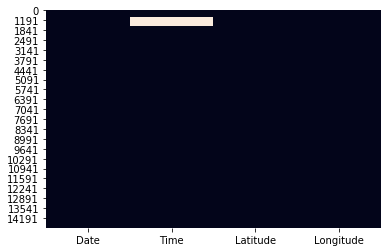

In [201]:
sns.heatmap(spraydata.isnull(), cbar=False)

In [202]:
#count of missing value is 584, so i decide to keep this column and only drop of the missing value 
spraydata = spraydata.dropna()

In [203]:
spraydata.to_csv('/Users/Elune/Desktop/spb/new/spray_cleaned.csv', index = False)

#### Weather 

In [204]:
# drop unused features
weatherdata.drop(['Water1', 'Depth', 'SnowFall', 'Depart'], axis = 1, inplace = True)

In [205]:
weatherdata.dtypes

Station        object
Date           object
Tmax           object
Tmin           object
Tavg           object
DewPoint       object
WetBulb        object
Heat           object
Cool           object
Sunrise        object
Sunset         object
CodeSum        object
PrecipTotal    object
StnPressure    object
SeaLevel       object
ResultSpeed    object
ResultDir      object
AvgSpeed       object
dtype: object

In [206]:
weatherdata['Tmax'] = weatherdata['Tmax'].astype('int')
weatherdata['Tmin'] = weatherdata['Tmin'].astype('int')

In [207]:
# add missing Tavg through calculating it with 'Tmax' and 'Tmin'
temp_df = weatherdata.loc[:, ['Tmax', 'Tmin', 'Tavg']]

def fill_missing_tavg(row):
    return row['Tavg'] if row['Tavg'] != 'M' else ceil((row['Tmax'] + row['Tmin']) / 2)

tavg = temp_df.apply(fill_missing_tavg, axis = 1)
weatherdata['Tavg'] = tavg.astype('int')

In [208]:
# Add other missing values except CodeSum
col_has_missing_val = ['WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
weatherdata[col_has_missing_val] = weatherdata[col_has_missing_val].replace([' ', '-', 'M', 'T', '  T'], np.nan)
weatherdata.fillna(method = 'ffill', inplace = True)

In [209]:
# Convert type
for col in ['WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']:
    weatherdata[col] = weatherdata[col].astype('float')

In [210]:
weatherdata['CodeSum'].replace(' ', 'SUN', inplace = True)

Convert Sunrise and Sunset to DayLen

In [212]:
def add_day_length(df):
    # function to convert obj to time delta
    def convert_to_timedelta_in_sec(col):
        # Convert obj to h:m:s
        col = col.apply(lambda x: x[:2] + ':' + x[2:] + ':00')
        # Convert to timedelta
        col = pd.to_timedelta(col)
        # Convert to sec
        col = col.apply(lambda x: x.total_seconds())
        return col
        
    df['Sunrise'] = convert_to_timedelta_in_sec(df['Sunrise'])
    df['Sunset'] = convert_to_timedelta_in_sec(df['Sunset'])
    df['DayLength'] = round((df['Sunset'] - df['Sunrise']) / 3600, 2)

In [214]:
add_day_length(weatherdata)

In [215]:
weatherdata.drop(['Sunrise', 'Sunset'], axis = 1, inplace = True)

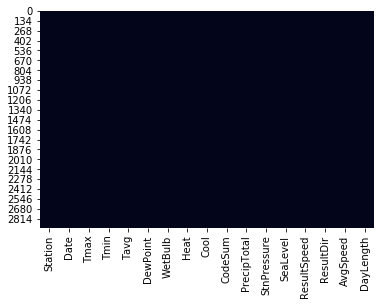

In [216]:
sns.heatmap(weatherdata.isnull(), cbar=False)

In [217]:
weatherdata.to_csv('/Users/Elune/Desktop/spb/new/weather_cleaned.csv', index = False)

## Feature Engineering

#### spray EDA and Feature Engineering

In [78]:
#for spray
spraydata.Date = pd.to_datetime(spraydata.Date, infer_datetime_format=True)

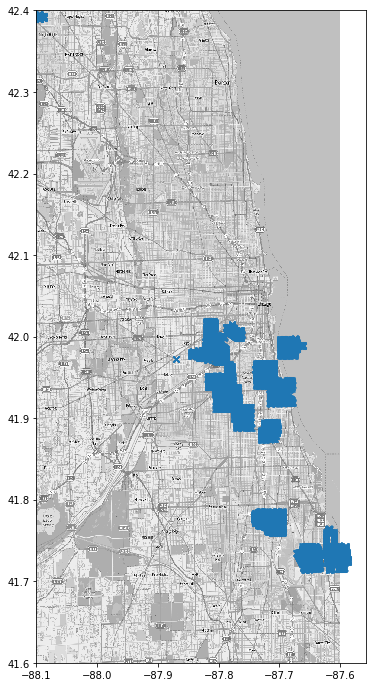

In [79]:
mapdata = np.loadtxt("/Users/Elune/Desktop/spb/mapdata.txt")
spray = pd.read_csv('/Users/Elune/Desktop/spb/spray.csv')[['Date', 'Time','Longitude', 'Latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88.1, -87.6, 41.6, 42.4)

plt.figure(figsize=(10,12))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

In [80]:
#analyze how this affect the number of mosquitos 

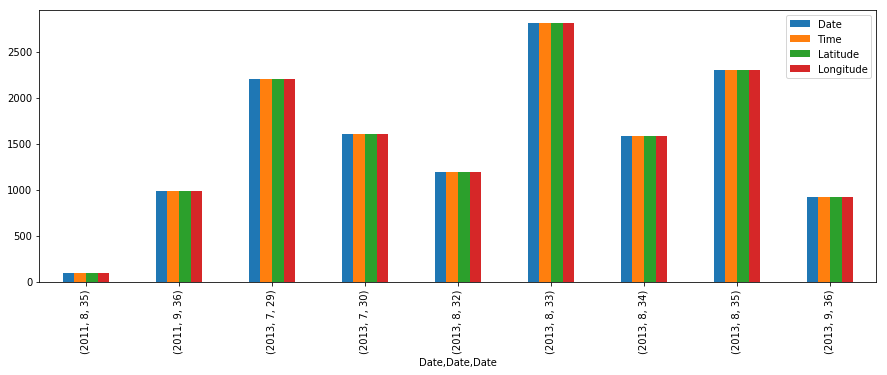

In [81]:
#for spray 
spraydata.groupby([spraydata["Date"]. dt.year, 
                         spraydata["Date"].dt.month, spraydata['Date'].dt.week]).count().plot(kind="bar", figsize=(15, 5))

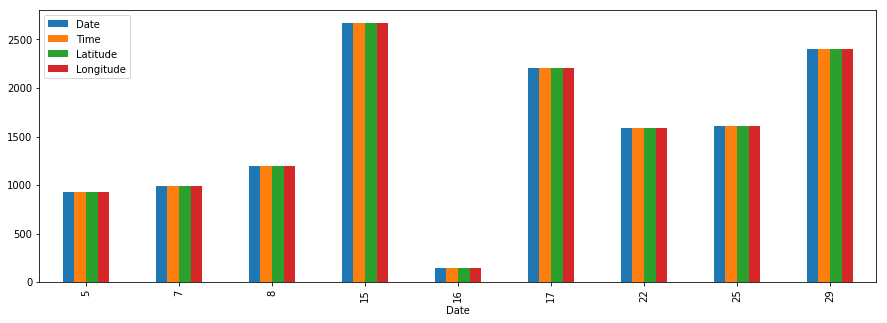

In [82]:
spraydata.groupby([spraydata["Date"]. dt.day]).count().plot(kind="bar", figsize=(15, 5))       

In [83]:
spraydata.head(10)

Date      Time          Latitude          Longitude
0 2011-08-29  18:56:58  42.3916233333333  -88.0891633333333
1 2011-08-29  18:57:08  42.3913483333333  -88.0891633333333
2 2011-08-29  18:57:18  42.3910216666667  -88.0891566666667
3 2011-08-29  18:57:28  42.3906366666667  -88.0891583333333
4 2011-08-29  18:57:38          42.39041  -88.0888583333333
5 2011-08-29  18:57:48         42.390395         -88.088315
6 2011-08-29  18:57:58  42.3906733333333  -88.0880016666667
7 2011-08-29  18:58:08  42.3910266666667  -88.0880016666667
8 2011-08-29  18:58:18  42.3914033333333  -88.0880033333333
9 2011-08-29  18:58:28  42.3917183333333         -88.087995

In [287]:
#There is 3 different months cross 2 years, and the seasonarity of spray is not that obvious
#we might need more data collection on this in order to provide more reliable information. 

### Train and Test feature engineering 

In [226]:
traindata['NumMosquitos'] = traindata['NumMosquitos'].astype('float')

In [227]:
traindata['NumMosquitos'].unique()

array([ 1.,  4.,  2.,  3.,  5.,  9.,  7., 10.,  8.,  6., 19., 20., 25.,
       16., 11., 12., 28., 18., 50., 35., 14., 22., 21., 37., 27., 13.,
       39., 29., 15., 17., 34., 26., 32., 47., 44., 23., 46., 48., 42.,
       33., 45., 24., 41., 38., 40., 36., 43., 49., 30., 31.])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135]),
 <a list of 136 Text xticklabel objects>)

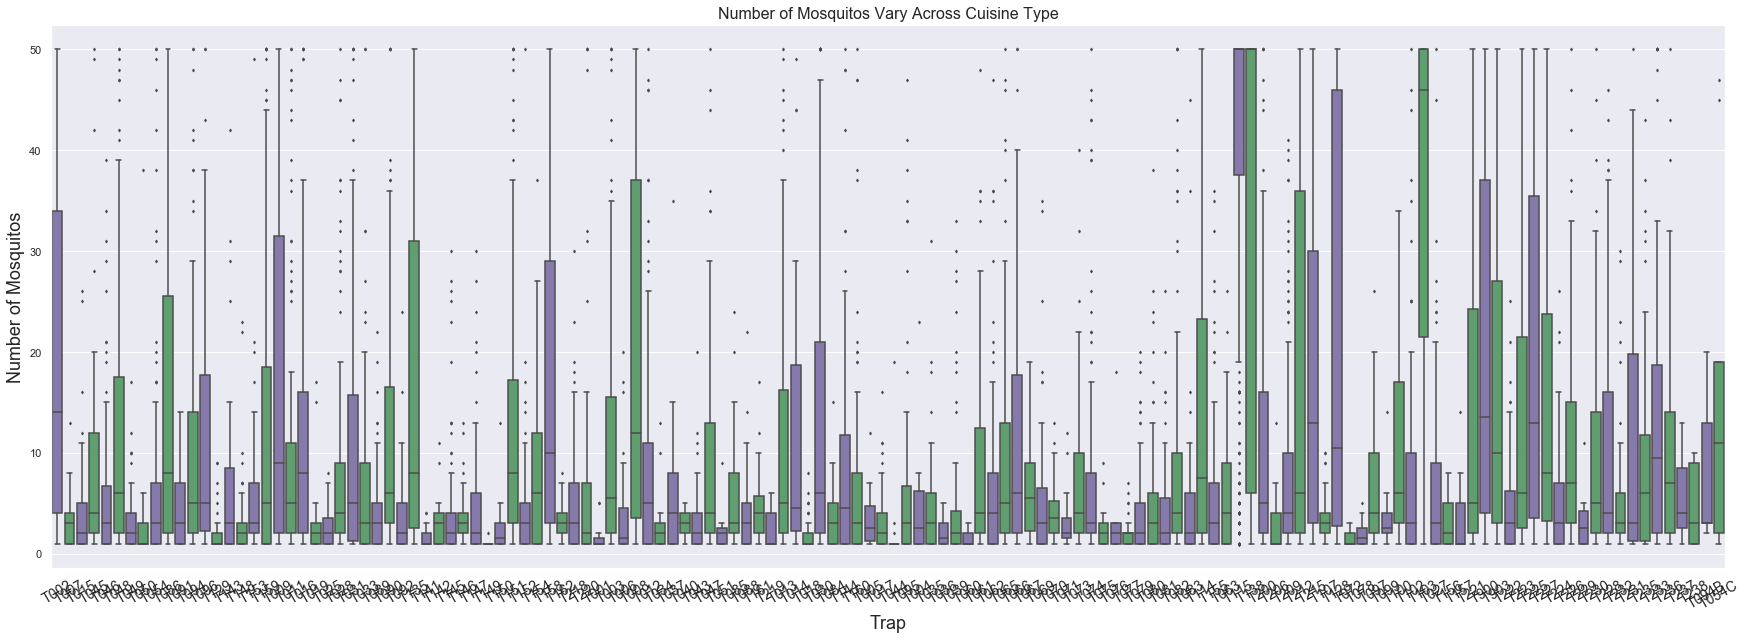

In [228]:
sns.set(style="white", palette="husl",)
sns.set(rc={'figure.figsize':(30,10)})
viscuisine=sns.boxplot(data=traindata, x="Trap", y="NumMosquitos",
            hue=None, palette=["m", "g"], 
            fliersize=2,)
plt.title('Number of Mosquitos Vary Across Cuisine Type', fontsize=16)
plt.xlabel('Trap',fontsize=18)
plt.ylabel('Number of Mosquitos', fontsize=18)
plt.xticks(rotation=30, fontsize=14)
#viscuisine.set_xticklabels(labels, rotation=30)

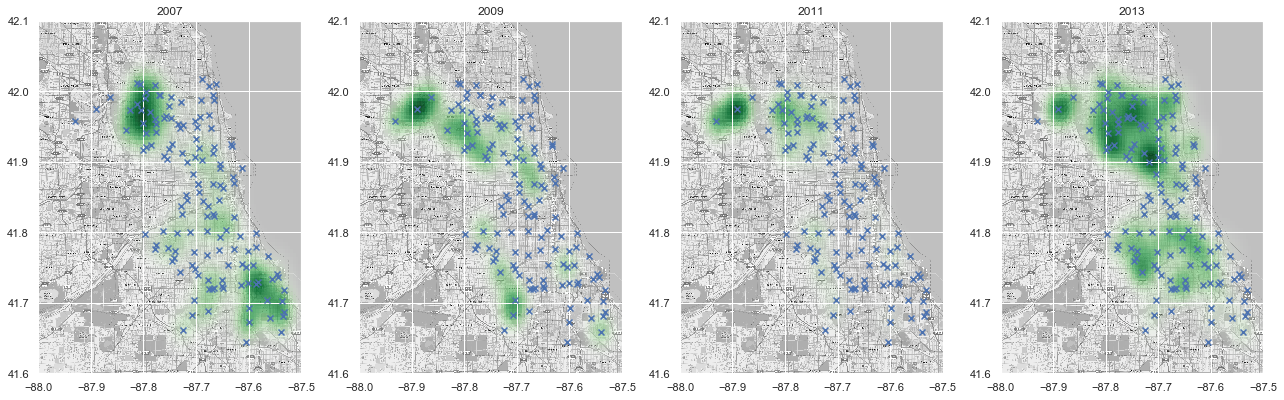

In [1636]:
mapdata = np.loadtxt("/Users/Elune/Desktop/spb/mapdata.txt")
traps = pd.read_csv('/Users/Elune/Desktop/spb/train.csv', parse_dates=['Date'])[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

alpha_cm = plt.cm.Greens
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(18,6))
for year, subplot in zip([2007, 2009, 2011, 2013], [141, 142, 143, 144]):
    sightings = traps[(traps['WnvPresent'] > 0) & (traps['Date'].apply(lambda x: x.year) == year)]
    sightings = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = sightings[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.tight_layout()
    locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x')
#Nile Summer

-----------------------------------------
Species of Misquito:
['CULEX ERRATICUS' 'CULEX PIPIENS' 'CULEX PIPIENS/RESTUANS'
 'CULEX RESTUANS' 'CULEX SALINARIUS' 'CULEX TARSALIS' 'CULEX TERRITANS']
--------------------------------------------------------------------------------
SKIPPING [1]:2007 (CULEX ERRATICUS)		No sightings
SKIPPING [2]:2009 (CULEX ERRATICUS)		No sightings
SKIPPING [3]:2011 (CULEX ERRATICUS)		No sightings
         [4]:2013 (CULEX ERRATICUS)
         [5]:2007 (CULEX PIPIENS)
         [6]:2009 (CULEX PIPIENS)
         [7]:2011 (CULEX PIPIENS)
         [8]:2013 (CULEX PIPIENS)
         [9]:2007 (CULEX PIPIENS/RESTUANS)
         [10]:2009 (CULEX PIPIENS/RESTUANS)
         [11]:2011 (CULEX PIPIENS/RESTUANS)
         [12]:2013 (CULEX PIPIENS/RESTUANS)
         [13]:2007 (CULEX RESTUANS)
         [14]:2009 (CULEX RESTUANS)
         [15]:2011 (CULEX RESTUANS)
         [16]:2013 (CULEX RESTUANS)
         [17]:2007 (CULEX SALINARIUS)
         [18]:2009 (CULEX SALINARIUS)
      

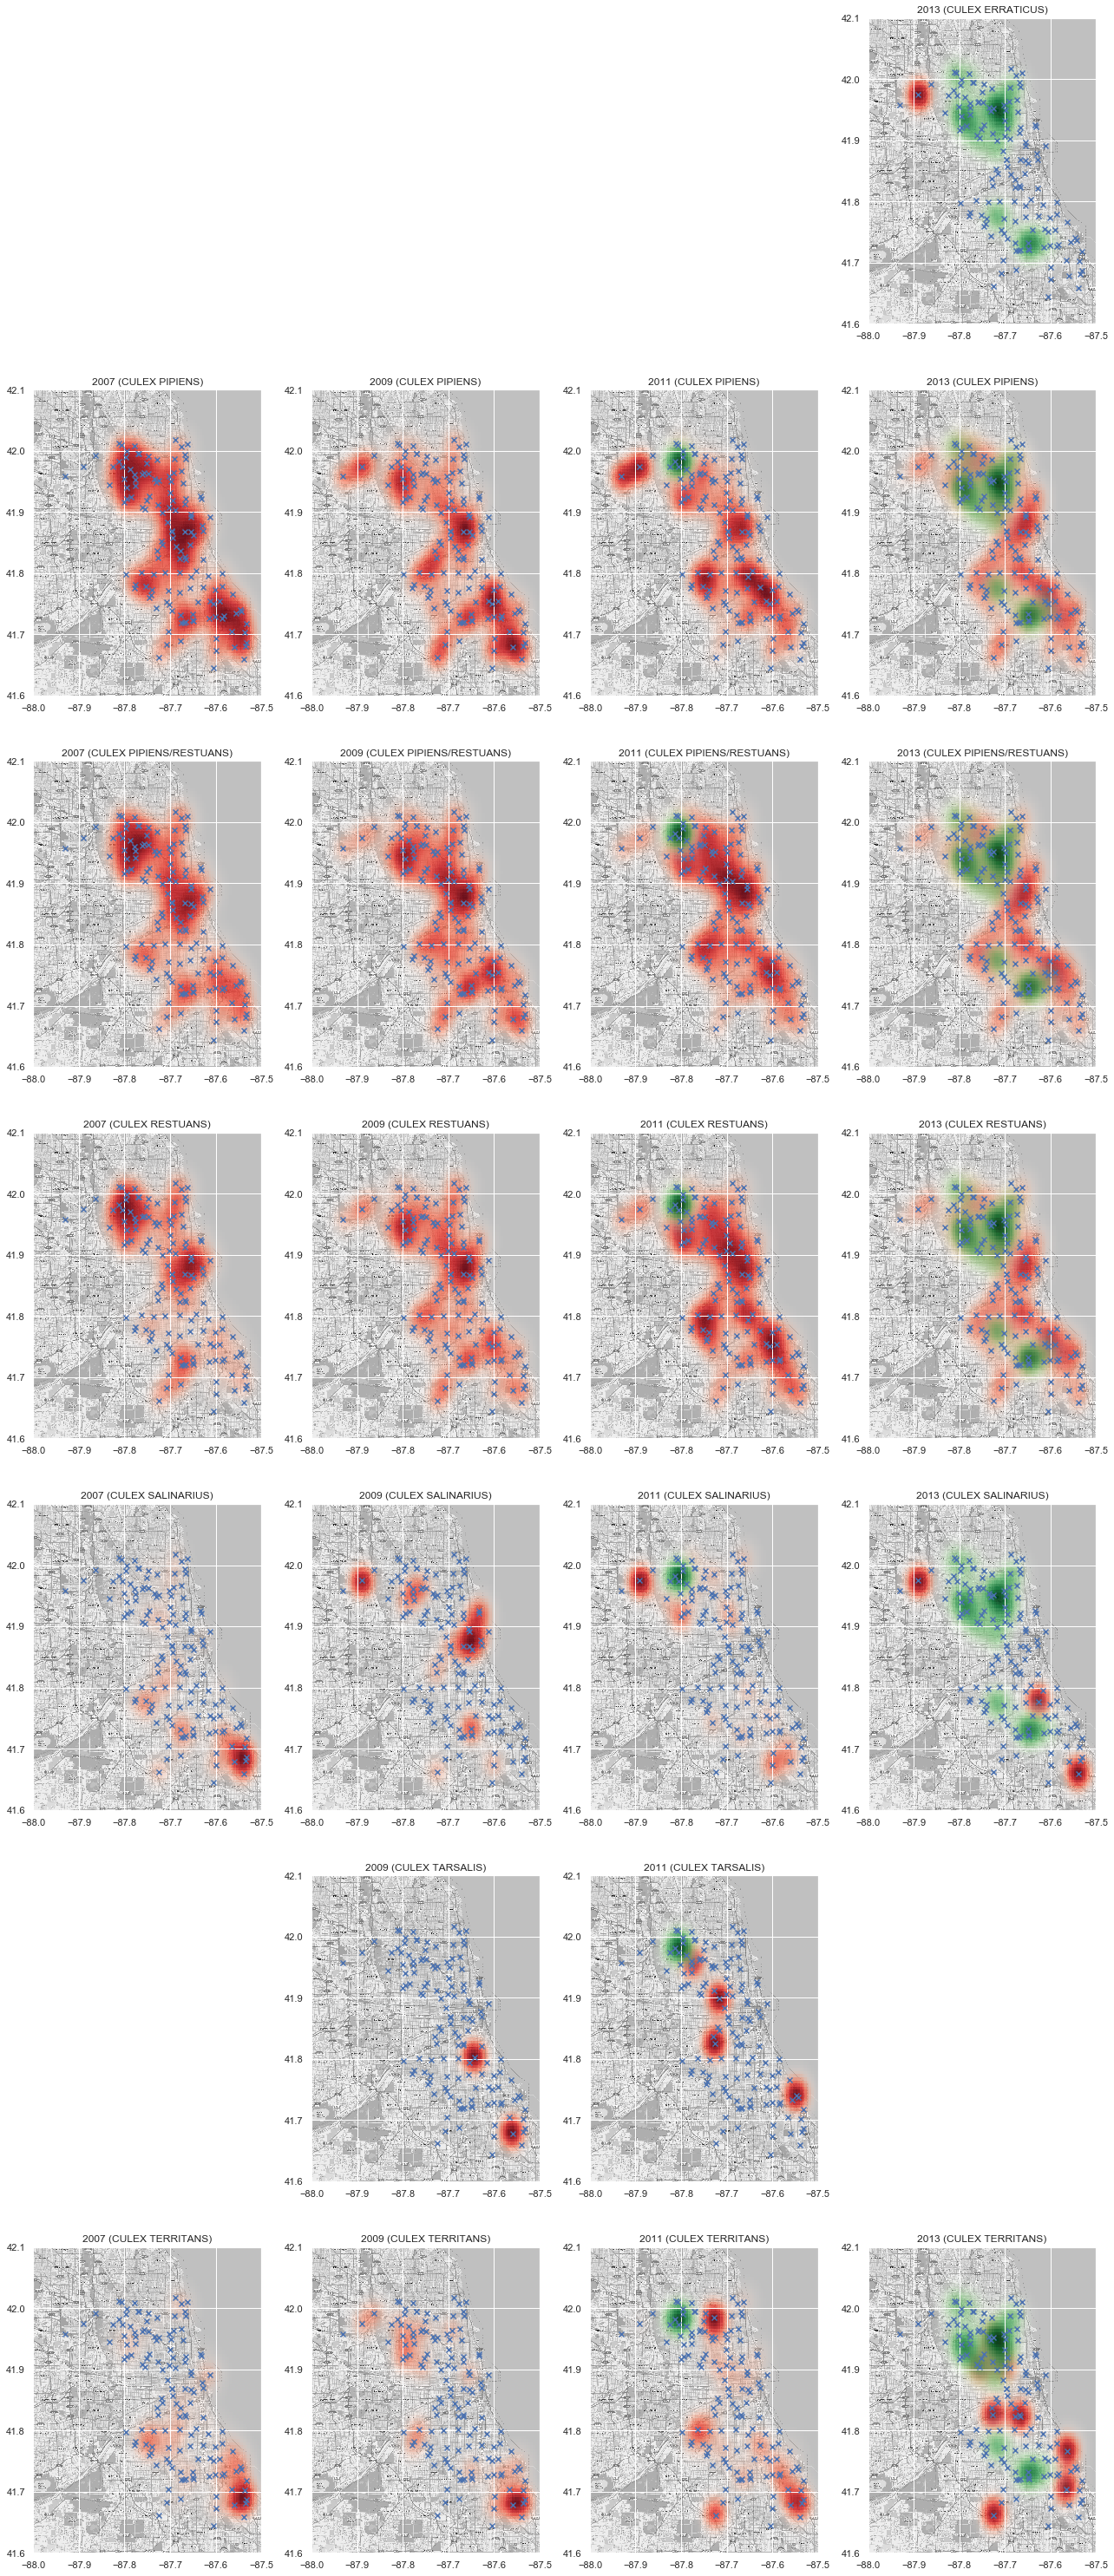

In [1638]:
def plotHeatMap(data, a_cm):
    if(len(data) > 0):
        X = data[['Longitude', 'Latitude']].values
        kd = KernelDensity(bandwidth=0.02)
        kd.fit(X)
        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        plt.imshow(zv, 
                   origin='lower', 
                   cmap=a_cm, 
                   extent=lon_lat_box, 
                   aspect=aspect)


train = pandas.read_csv("/Users/Elune/Desktop/spb/train.csv")
species = pandas.np.unique(traindata['Species'])
print("Species of Misquito:")
print(species)
spray = pandas.read_csv("/Users/Elune/Desktop/spb/spray.csv", parse_dates=['Date'])
weather = pandas.read_csv("/Users/Elune/Desktop/spb/weather.csv")
print("--------------------------------------------------------------------------------")

traps = pandas.read_csv('/Users/Elune/Desktop/spb/train.csv', parse_dates=['Date'])[['Date', 'Trap','Longitude', 'Latitude', 'Species', 'WnvPresent']]
mapdata = np.loadtxt("/Users/Elune/Desktop/spb/mapdata.txt")

alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
alpha_mcm = plt.cm.Greens
alpha_mcm._init()
alpha_mcm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

subplot = 0
numSpcs = len(species)
plt.figure(figsize=(18,6*numSpcs))
for spcsIndx in range(numSpcs):
    for year in [2007, 2009, 2011, 2013]:
        subplot += 1
        sightings = spray[(spray['Date'].apply(lambda x: x.year) == year)]
        mSightings = traps[(traps['Species'] == species[spcsIndx])
                          & (traps['Date'].apply(lambda x: x.year) == year)]
        mSightings = mSightings.groupby(['Date', 'Trap', 'Longitude', 'Latitude', 'Species']).max()['WnvPresent'].reset_index()
        if(len(mSightings) <= 0):
            print("SKIPPING [" + str(subplot) + "]:" + str(year) + " (" + species[spcsIndx] + ")\t\tNo sightings")
            continue

        plt.subplot(numSpcs, 4, subplot)
        plt.gca().set_title(str(year) + " (" + species[spcsIndx] + ")")
        plt.imshow(mapdata, 
                   cmap=plt.get_cmap('gray'), 
                   extent=lon_lat_box, 
                   aspect=aspect)
        plotHeatMap(mSightings, alpha_cm)
        plotHeatMap(sightings, alpha_mcm)

        print("         [" + str(subplot) + "]:" + str(year) + " (" + species[spcsIndx] + ")")
        plt.tight_layout()
        locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
        plt.scatter(locations[:,0], locations[:,1], marker='x')

plt.savefig('/Users/Elune/Desktop/heatmap.png')

#for trap

In [229]:
traindata['Date'] = pd.to_datetime(traindata['Date'], infer_datetime_format=True)

In [230]:
traindata[traindata.duplicated(keep=False)]

Date                 Species  Trap   Latitude   Longitude  \
98    2007-06-26  CULEX PIPIENS/RESTUANS  T086  41.688324  -87.676709   
99    2007-06-26  CULEX PIPIENS/RESTUANS  T086  41.688324  -87.676709   
293   2007-07-11  CULEX PIPIENS/RESTUANS  T086  41.688324  -87.676709   
295   2007-07-11  CULEX PIPIENS/RESTUANS  T086  41.688324  -87.676709   
350   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587  -87.707973   
351   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587  -87.707973   
353   2007-07-11  CULEX PIPIENS/RESTUANS  T158  41.682587  -87.707973   
511   2007-07-18          CULEX RESTUANS  T044  41.883284  -87.705085   
512   2007-07-18          CULEX RESTUANS  T044  41.883284  -87.705085   
530   2007-07-18  CULEX PIPIENS/RESTUANS  T138  41.726465  -87.585413   
531   2007-07-18  CULEX PIPIENS/RESTUANS  T138  41.726465  -87.585413   
547   2007-07-18  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
548   2007-07-18  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
586   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
587   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
588   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
589   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
590   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
591   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
593   2007-07-19  CULEX PIPIENS/RESTUANS  T212  41.680946  -87.535198   
601   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
602   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
603   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
604   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
605   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
606   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
607   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
608   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
609   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
611   2007-07-25  CULEX PIPIENS/RESTUANS  T115  41.673408  -87.599862   
...          ...                     ...   ...        ...         ...   
9315  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9318  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9319  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9323  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9324  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9327  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9329  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9330  2013-08-01  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9676  2013-08-15           CULEX PIPIENS  T900  41.974689  -87.890615   
9678  2013-08-15           CULEX PIPIENS  T900  41.974689  -87.890615   
9901  2013-08-29  CULEX PIPIENS/RESTUANS  T090  41.868077  -87.666901   
9902  2013-08-29  CULEX PIPIENS/RESTUANS  T090  41.868077  -87.666901   
9968  2013-08-29  CULEX PIPIENS/RESTUANS  T009  41.992478  -87.862995   
9969  2013-08-29  CULEX PIPIENS/RESTUANS  T009  41.992478  -87.862995   
9973  2013-08-29  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9974  2013-08-29  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9975  2013-08-29  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9976  2013-08-29  CULEX PIPIENS/RESTUANS  T900  41.974689  -87.890615   
9988  2013-08-29           CULEX PIPIENS  T900  41.974689  -87.890615   
9992  2013-08-29           CULEX PIPIENS  T900  41.974689  -87.890615   
10011 2013-08-29  CULEX PIPIENS/RESTUANS  T233  42.009876  -87.807277   
10013 2013-08-29  CULEX PIPIENS/RESTUANS  T233  42.009876  -87.807277   
10101 2013-09-06           CULEX PIPIENS  T063   41.82561  -87.726549 

In [232]:
traindata = traindata.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy', 'WnvPresent'])['NumMosquitos', 'RowSum'].agg('sum').reset_index()

In [233]:
traindata.rename(columns={'NumMosquitos':'MosqSum', 'WnvPresent':'WnvSum'}, inplace = True)

In [236]:
traindata.head()

Date                 Species  Trap   Latitude   Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922  -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002   41.95469  -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089  -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108  -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343  -87.694259   

  AddressAccuracy WnvSum  MosqSum  RowSum  
0               8      0      1.0       1  
1               9      0      1.0       1  
2               8      0      1.0       1  
3               8      0      1.0       1  
4               8      0      1.0       1

In [239]:
traindata['MosqSum'] = traindata['MosqSum'].astype('int')
traindata['WnvSum'] = traindata['WnvSum'].astype('int')

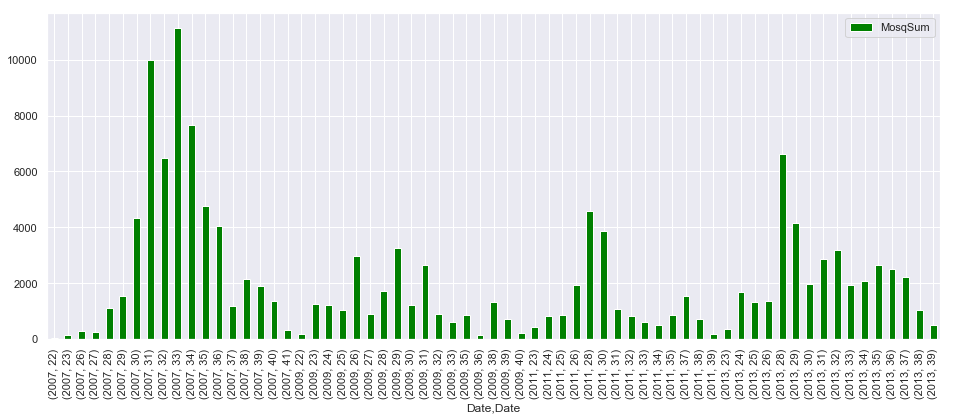

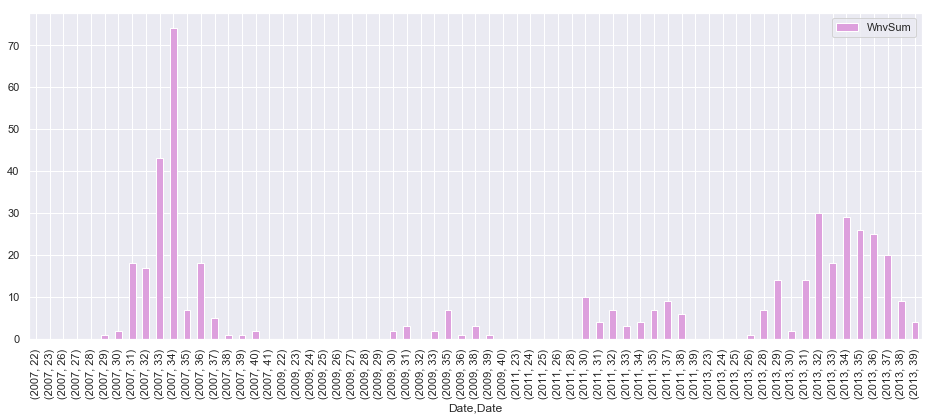

In [241]:
 #Total number of Mosquitos found per week, origonal data
traindata[['MosqSum']].groupby([traindata["Date"].dt.year,
                               traindata["Date"].dt.week]).sum().plot(kind="bar",figsize=(16, 6), color='green')

# Total batches of Wnv found per week, origional data
traindata[['WnvSum']].groupby([traindata["Date"].dt.year,
                               traindata["Date"].dt.week]).sum().plot(kind="bar",color='plum',figsize=(16, 6))


In [1538]:
#factorize trap
train_agg.Trap,mapping_index=pd.Series(train_agg.Trap).factorize() 

#### Helpers

In [242]:
R = 6373.0

def get_distance(lat1, lng1, lat2, lng2):
    lat1 = radians(lat1)
    lng1 = radians(lng1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlng / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c

In [243]:
def add_features_for_trap(df):
    def convert_date():
        df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)
        df['day'] = df['Date'].dt.dayofweek
        df['week'] = df['Date'].dt.week
        
    def convert_coordinate():
        lat = np.radians(df['Latitude'])
        lng = np.radians(df['Longitude'])
        
        df['CoordX'] = np.cos(lat) * np.cos(lng)
        df['CoordY'] = np.cos(lat) * np.sin(lng)
        df['CoordZ'] = np.sin(lat)
        
    def get_distance_to_wood(row):
        lat = row['Latitude']
        lng = row['Longitude']
        target_lat = max(min(lat, 42.0250), 41.8388)
        target_lng = -87.8472
        return round(get_distance(lat, lng, target_lat, target_lng), 2)
    
    convert_date()
    convert_coordinate()
    df['DisToWoods'] = df.apply(get_distance_to_wood, axis = 1)

In [245]:
traindata['Latitude'] = traindata['Latitude'].astype('float')
traindata['Longitude'] = traindata['Longitude'].astype('float')
add_features_for_trap(traindata)

In [246]:
traindata.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

  AddressAccuracy  WnvSum  MosqSum  RowSum  day  week    CoordX    CoordY  \
0               8       0        1       1    1    22  0.030242 -0.745654   
1               9       0        1       1    1    22  0.028535 -0.743126   
2               8       0        1       1    1    22  0.028218 -0.742912   
3               8       0        1       1    1    22  0.030480 -0.744071   
4               8       0        1       1    1    22  0.029936 -0.743484   

     CoordZ  DisToWoods  
0  0.665646       18.42  
1  0.668543        3.82  
2  0.668794        1.85  
3  0.667405       15.98  
4  0.668084       12.66

In [247]:
traindata.to_csv('/Users/Elune/Desktop/spb/new/train_agg.csv')

#### Bring to test

Add row sum

In [249]:
testdata['Duplicated'] = testdata.duplicated(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy'])
testdata['RowSum'] = testdata['Duplicated'].apply(lambda x: 1 if x else 0)

In [286]:
#take longer to process because of more data points
def fill_dup(row):
    size = 0
    if row['Duplicated'] == True:
        size = testdata[(testdata['Date'] == row['Date']) & (testdata['Species'] == row['Species']) & (testdata['Trap'] == row['Trap']) & (testdata['Latitude'] == row['Latitude']) & (testdata['Longitude'] == row['Longitude'])].shape[0] - 1
    
    return size
    
testdata['RowSum'] = testdata.apply(fill_dup, axis = 1)
testdata.drop(['Duplicated'], axis = 1, inplace = True)

In [ ]:
testdata.head()

In [ ]:
add_features_for_trap(testdata)

In [ ]:
testdata.head()

In [ ]:
testdata.to_csv('/Users/Elune/Desktop/spb/new/test_agg.csv')

#### Weather

In [252]:
weatherdata.dtypes

Station         object
Date            object
Tmax             int64
Tmin             int64
Tavg             int64
DewPoint        object
WetBulb        float64
Heat           float64
Cool           float64
CodeSum         object
PrecipTotal    float64
StnPressure    float64
SeaLevel       float64
ResultSpeed     object
ResultDir       object
AvgSpeed       float64
DayLength      float64
dtype: object

In [253]:
columns_to_int = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', \
                  'Cool',  'ResultSpeed', 'ResultDir', 'AvgSpeed']

for col in columns_to_int:
     weatherdata[col] = weatherdata[col].astype('float')

In [254]:
weatherdata['CodeSum'].unique()

array(['SUN', 'BR', 'BR HZ', 'HZ', 'RA', 'RA BR', 'TSRA RA BR', 'RA VCTS',
       'TSRA RA', 'RA HZ', 'TSRA RA BR HZ', 'TSRA BR HZ', 'RA BR HZ VCTS',
       'TSRA RA HZ', 'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS', 'TSRA HZ',
       'VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS', 'TS TSRA RA BR HZ VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'TS TSRA BR HZ', 'RA BR HZ',
       'TSRA RA DZ BR HZ', 'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS TSRA BR', 'TS RA', 'RA BCFG BR',
       'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'TS BR', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'TS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ F

In [255]:
weatherdata.loc[weatherdata['CodeSum'] == 'RA BR', 'CodeSum'] = ['RA']
weatherdata.loc[weatherdata['CodeSum'] == 'BR HZ', 'CodeSum'] = ['BR']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA BR HZ VCTS', 'CodeSum'] = ['TSRA VCTS']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA RA BR VCTS', 'CodeSum'] = ['TSRA VCTS']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA RA BR HZ VCTS', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'DZ BR', 'CodeSum'] = ['RA']
weatherdata.loc[weatherdata['CodeSum'] == 'RA BR HZ', 'CodeSum'] = ['RA']
weatherdata.loc[weatherdata['CodeSum'] == 'HZ', 'CodeSum'] = ['BR']
weatherdata.loc[weatherdata['CodeSum'] == 'VCTS', 'CodeSum'] = ['TSRA VCTS']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA RA DZ BR HZ', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA RA', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA BR HZ', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA RA BR', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA RA BR', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'BR', 'CodeSum'] = ['BR']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA HZ', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA BR', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'RA DZ BR', 'CodeSum'] = ['RA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA BR HZ', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA RA VCTS', 'CodeSum'] = ['TSRA VCTS']
weatherdata.loc[weatherdata['CodeSum'] == 'TSRA BR', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS BR', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'TS', 'CodeSum'] = ['TSRA']
weatherdata.loc[weatherdata['CodeSum'] == 'FG BR HZ', 'CodeSum'] = ['BR']
weatherdata.loc[weatherdata['CodeSum'] == 'TS TSRA RA FG BR HZ', 'CodeSum'] = ['TSRA']

In [260]:
weatherdata['CodeSum'].unique()

array(['SUN', 'BR', 'RA', 'TSRA', 'RA VCTS', 'RA HZ', 'TSRA RA BR HZ',
       'RA BR HZ VCTS', 'TSRA RA HZ', 'TSRA VCTS', 'TSRA BR HZ FU',
       'TSRA RA HZ FU', 'BR HZ FU', 'TSRA RA VCTS', 'HZ VCTS',
       'RA BR VCTS', 'TS TSRA RA BR HZ', 'TS RA BR', 'TS TSRA RA',
       'TS TSRA RA BR VCTS', 'TS RA', 'RA BCFG BR', 'RA DZ FG+ BCFG BR',
       'RA FG+ MIFG BR', 'RA DZ', 'TS TSRA RA HZ', 'TSRA RA FG+ FG BR',
       'TSRA DZ FG+ FG BR HZ', 'RA BR SQ', 'TS TSRA',
       'TSRA RA BR HZ VCTS', 'BR VCTS', 'FG+ BR HZ', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR HZ', 'RA BR FU', 'TS BR HZ', 'DZ',
       'FG+ BR', 'FG+ FG BR', 'FG+ MIFG BR', 'TSRA RA FG BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG BR HZ',
       'TS TSRA RA FG BR', 'BR HZ VCFG', 'TS RA FG+ FG BR',
       'TSRA RA FG+ BR', 'RA DZ FG+ FG BR', 'FU', 'TS TSRA VCFG',
       'TS TSRA HZ', 'TS TSRA GR RA BR', 'RA FG BR', 'HZ FU',
       'RA BR HZ FU', 'MIFG BCFG BR', 'FG+ BCFG BR',
       'TSRA RA FG+ FG BR HZ', 'FG+'

In [261]:
weatherdata.shape

(2944, 17)

In [285]:
#create a new column to describe the difference between Tavg and DewPoint called  'humidity'
weatherdata['Humidity']=weatherdata['Tavg']-weatherdata['DewPoint']

#this can be demonstrated through below boxplot. The higher 'humidity' means more differences, so
#that the real humidity is higher. 
'''sns.set(style="white", palette="pastel",)
sns.set(rc={'figure.figsize':(16,8.27)})
viscuisine=sns.boxplot(data=train, x="CodeSum", y="Humidity",
            hue=None, palette=["m", "g"], 
            fliersize=3,width=0.6,linewidth=1)
plt.title('Weather and Humidity', fontsize=16)
plt.xlabel('Weather',fontsize=18,)
plt.ylabel('-Humidity', fontsize=18)
plt.xticks(rotation=30, fontsize=14)
#viscuisine.set_xticklabels(labels, rotation=30)
'''

'sns.set(style="white", palette="pastel",)\nsns.set(rc={\'figure.figsize\':(16,8.27)})\nviscuisine=sns.boxplot(data=train, x="CodeSum", y="Humidity",\n            hue=None, palette=["m", "g"], \n            fliersize=3,width=0.6,linewidth=1)\nplt.title(\'Weather and Humidity\', fontsize=16)\nplt.xlabel(\'Weather\',fontsize=18,)\nplt.ylabel(\'-Humidity\', fontsize=18)\nplt.xticks(rotation=30, fontsize=14)\n#viscuisine.set_xticklabels(labels, rotation=30)\n'

In [264]:
#save feature engineeried data
weatherdata.to_csv('/Users/Elune/Desktop/spb/new/weather_featured.csv', index = False)

#### now merge weather with both train and test file

In [265]:
weatherdata['Date'] = pd.to_datetime(weatherdata['Date'], infer_datetime_format = True)

In [270]:
col_to_join = weatherdata.dtypes.index
col_to_join = col_to_join[2:]

In [271]:
station1_lat, station1_lng = 41.995, -87.933
station2_lat, station2_lng = 41.786, -87.752

In [276]:
def join_weather_data(df):
    def mark_duplicate():
        df['Duplicate'] = df.duplicated(['Date', 'Latitude', 'Longitude', 'Trap'])
        
    def join():
        # iterate
        for idx, row in df.iterrows():
            if row['Duplicate'] ==True:
                continue
            stations = weatherdata[weatherdata['Date'] == row['Date']]
            station_num = len(stations)
            # No station
            if station_num == 0:
                continue
            # One station
            elif station_num == 1:
                station_to_pick = stations.iloc[0]
            # Two station
            else:
                station1 = stations.iloc[0]
                station2 = stations.iloc[1]

                trap_lat, trap_lng = row[['Latitude', 'Longitude']]

                dis1 = get_distance(trap_lat, trap_lng, station1_lat, station1_lng)
                dis2 = get_distance(trap_lat, trap_lng, station2_lat, station2_lng)

                station_to_pick = station1 if dis1 < dis2 else station2

            for col in col_to_join:
                df.loc[idx, col] = station_to_pick[col]
                
    def remove_duplicate():
        df.drop(['Duplicate'], axis = 1, inplace = True)
    
    # front fill na since weather data should be same for same trap on same day
    def fill_na():
        df.fillna(method = 'ffill', inplace = True)
        
    mark_duplicate()
    join()
    remove_duplicate()
    fill_na()

In [277]:
tcpy = traindata.copy()
join_weather_data(tcpy)

In [279]:
traindata = tcpy

In [280]:
traindata.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

  AddressAccuracy  WnvSum  MosqSum  RowSum  day  ...  Cool  CodeSum  \
0               8       0        1       1    1  ...  12.0       BR   
1               9       0        1       1    1  ...   9.0       BR   
2               8       0        1       1    1  ...   9.0       BR   
3               8       0        1       1    1  ...  12.0       BR   
4               8       0        1       1    1  ...  12.0       BR   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0          0.0        29.44     30.09          5.8       16.0       7.4   
1          0.0        29.39     30.11          5.8       18.0       6.5   
2          0.0        29.39     30.11          5.8       18.0       6.5   
3          0.0        29.44     30.09          5.8       16.0       7.4   
4          0.0        29.44     30.09          5.8       16.0       7.4   

   DayLength  Humidity  
0      14.93      18.0  
1      14.93      16.0  
2      14.93      16.0  
3      14.93      18.0  
4      14.93      18.0  

[5 rows x 31 columns]

In [282]:
traindata.to_csv('/Users/Elune/Desktop/spb/new/modeltrain.csv', index = False)
modeltest=test.to_csv('/Users/Elune/Desktop/spb/modeltest.csv')

In [ ]:
#finished 